## Introduction


In this lab, you will build and train a CNN model to classify electronic symbols. The dataset available was created a long time ago (2015), back then this problem was sort out using classic ANN, but it was necessary to extract some features like rotation angle, rescale image, using OpènCV in order to achieve a better performance.
<br> This time the idea is create a CNN model that could automatically extract features from the dataset to make it not sensible of noise in the image like symbol rotation, rescale or offset. 

## Dataset

The dataset consist in three types of pasive electronic symbol component, "capacitor", "inductor" and "resistance". The original image of each one is "R1.png", "C1.png" and "L1.png". Others pictures were created based on the original one, making random rotation and rescale, to complete a possible dataset for testing.

## Import Libraries

In [2]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model
import tensorflow as tf

Using TensorFlow backend.


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if(gpus):
    try:
        for gpu in gpus:            
            tf.config.experimental.set_memory_growth(gpu,True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
         # Visible devices must be set before GPUs have been initialized
        print(e)
gpus

1 Physical GPUs, 1 Logical GPUs


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<a id="item42"></a>

# Construct ImageDataGenerator Instances

In this part, we will create ImageDataGenerator for the training set and another one for the validation set. Our model will be compared with VGG16 that was originally trained on 224 × 224 images, so we have to scale the image to 224x224

In [4]:
# Define Global Constants
num_classes = 3
image_resize = 224
batch_size_training = 12
batch_size_validation = 12

In [5]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [6]:
train_generator = data_generator.flow_from_directory(
    'symbols/train',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical')

Found 180 images belonging to 3 classes.


In [7]:
validation_generator = data_generator.flow_from_directory(
    'symbols/valid',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical')

Found 36 images belonging to 3 classes.


## Create CNN Model

In this part we are going to create a Keras CNN model from scratch.
<br>Architecture of our model

- (Input) -> [batch_size, 224, 2224, 1]  >> Apply 32 filter of [3x3]
- (Convolutional layer 1)  -> [batch_size, 224, 224, 32]
- (ReLU 1)  -> [?, 224, 224, 32]
- (Max pooling 1) -> [?, 112, 112, 32]
- (Convolutional layer 2)  -> [?, 112, 112, 64] 
- (ReLU 2)  -> [?, 112, 112, 64] 
- (Max pooling 2)  -> [?, 56, 56, 64] 
- (ReLU 3)  -> [?, 28, 28, 128] 
- (Max pooling 3)  -> [?, 28, 28, 128] 
- [fully connected layer 3] -> [1x1024]
- [ReLU 3]  -> [1x2048]
- [Drop out]  -> [1x2048]
- [fully connected layer 4] -> [1x3]

### Build and fit model

In [8]:
my_model = Sequential()

In [ ]:
# How the output shape of each layer is calculated (For reference only):
# Z = ( (N+2*p)-f+1)/S
# N: inputer shape of that layer
# f: size of kernel filter
# s: strides
# p: padding+3

In [9]:

# Layer 1
# model.add(ZeroPadding2D(padding=(1,1),input_shape=(3,224,224), data_format='channels_first'))
# (N-K+1)/S
my_model.add(ZeroPadding2D(padding=(1,1),input_shape=(224,224,3))) # --> (226,226,1)
my_model.add(Convolution2D(32, 3, 3, activation='relu'))  # --> (226-3+1)/1 --> (224,224,32)
my_model.add(ZeroPadding2D(padding=(1,1))) # --> (226,226,32)
my_model.add(Convolution2D(32, 3, 3, activation='relu')) # --> (226-3+1)/1 --> (224,224,32)
my_model.add(MaxPooling2D((2,2), strides=(2,2))) # --> (224-2+1)/2 --> (112,112,112)

# Layer 2
my_model.add(ZeroPadding2D(padding=(1,1)))
my_model.add(Convolution2D(64, 3, 3, activation='relu'))
my_model.add(ZeroPadding2D(padding=(1,1)))
my_model.add(Convolution2D(64, 3, 3, activation='relu'))
my_model.add(MaxPooling2D((2,2), strides=(2,2)))

# Layer 3
my_model.add(ZeroPadding2D(padding=(1,1)))
my_model.add(Convolution2D(128, 3, 3, activation='relu'))
my_model.add(ZeroPadding2D(padding=(1,1)))
my_model.add(Convolution2D(128, 3, 3, activation='relu'))
my_model.add(MaxPooling2D((2,2), strides=(2,2)))

# Layer 4: Fully Connected
my_model.add(Flatten())
# my_model.add(Dense(2048, activation='relu'))
# my_model.add(Dropout(0.5))

# Layer 6: Outputlayer
my_model.add(Dense(3, activation='softmax'))

my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 226, 226, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 114, 114, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)     

C:\Python37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  """
C:\Python37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  import sys
C:\Python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  if sys.path[0] == '':
C:\Python37\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
C:\Python37\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
C:\Python37\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`


In [10]:
# Compile model using the adam optimizer.
my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
num_epochs = 20

In [12]:
fit_history = my_model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,
)

Epoch 1/20
15/15 [==============================] - 8s 519ms/step - loss: 28.2613 - accuracy: 0.6667 - val_loss: 0.0111 - val_accuracy: 1.0000
Epoch 2/20
15/15 [==============================] - 4s 245ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/20
15/15 [==============================] - 4s 252ms/step - loss: 4.6822e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/20
15/15 [==============================] - 4s 239ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/20
15/15 [==============================] - 4s 266ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/20
15/15 [==============================] - 4s 286ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/20
15/15 [==============================] - 4s 260ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_l

In [17]:
my_model.save('classifier_my_model.h5')

In [ ]:
# Load the model
my_model = load_model('classifier_my_model.h5')

# Build, Compile and Fit VGG16 Model

In [18]:
train_generator = data_generator.flow_from_directory(
    'symbols/train',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical')

Found 180 images belonging to 3 classes.


In [19]:
validation_generator = data_generator.flow_from_directory(
    'symbols/valid',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical')

Found 36 images belonging to 3 classes.


In [23]:
vgg16_model = Sequential()

In [24]:
# in order to leave out the output layer of the pre-trained model, we will use the argument include_top and set it to False.
vgg16_model.add(VGG16(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    ))

In [25]:
# Define our output layer as a Dense layer, that consists of two nodes and uses the Softmax function as the activation function.
vgg16_model.add(Dense(num_classes, activation='softmax'))
vgg16_model.layers[0].trainable = False
vgg16_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
Total params: 14,716,227
Trainable params: 1,539
Non-trainable params: 14,714,688
_________________________________________________________________


In [26]:
# Compile model using the adam optimizer.
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
num_epochs = 10

In [28]:
fit_history = vgg16_model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,
)

Epoch 1/10
15/15 [==============================] - 9s 569ms/step - loss: 4.6290 - accuracy: 0.2944 - val_loss: 0.7779 - val_accuracy: 0.6389
Epoch 2/10
15/15 [==============================] - 4s 291ms/step - loss: 0.4017 - accuracy: 0.8278 - val_loss: 0.0382 - val_accuracy: 1.0000
Epoch 3/10
15/15 [==============================] - 4s 290ms/step - loss: 0.0497 - accuracy: 0.9833 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 4/10
15/15 [==============================] - 5s 303ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 5/10
15/15 [==============================] - 4s 295ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 6/10
15/15 [==============================] - 5s 364ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 7/10
15/15 [==============================] - 5s 301ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 

In my case I run the trainin part at clobal (https://colab.research.google.com/) to get model fir in 2 minutes
The results was:
Epoch 1/2
301/301 [==============================] - 113s 375ms/step - loss: 0.1124 - acc: 0.9612 - val_loss: 0.0308 - val_acc: 0.9920
Epoch 2/2
301/301 [==============================] - 106s 351ms/step - loss: 0.0237 - acc: 0.9940 - val_loss: 0.0171 - val_acc: 0.9954

In [29]:
# Then I save the model at colab and download it to continue working at jupyter
vgg16_model.save('classifier_vgg16_model.h5')

In [18]:
# Load the model
vgg16_model = load_model('classifier_vgg16_model.h5')

C:\Python37\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


<a id="item43"></a>

## Test and compare models

Create ImageDataGenerator for test

In [30]:
evaluate_generator = data_generator.flow_from_directory(
    'symbols/test',
    target_size=(image_resize, image_resize),
    shuffle=False)

Found 12 images belonging to 3 classes.


In [31]:
vgg16_evaluate_history = vgg16_model.evaluate_generator(
    evaluate_generator,
    verbose=1,
)

1/1 [==============================] - 1s 551ms/step


In [32]:
# VGG16 performance
vgg16_evaluate_history

[0.1151948794722557, 1.0]

In [33]:
my_evaluate_history_resnet = my_model.evaluate_generator(
    evaluate_generator,
    verbose=1,
)

1/1 [==============================] - 0s 417ms/step


In [34]:
# My model performance
my_evaluate_history_resnet

[14.925365447998047, 0.5]

# Results

The results are the expected, the VGG16 has better accuracy and performance. Because the VGG16 is a pre-trained model.
<br> Our model is trained with few images, we need a bigger dataset with more differents images to exatract features.
<br> We will continue using de VGG16 in the follow section.

## Show predict results on

In this part, we will create a predict_generator to test and show the test dataset. This test has the worse and difficult images to classify.
<br> System will save results in a list associated to each class.

<center>
    <ul style="list-style-type:none">
        <li>Capacitor</li>  
        <li>Inductor</li> 
        <li>Resistance</li>
        <li>...</li>
    </ul>
</center>

In [35]:
vgg16_predict = vgg16_model.predict_generator(
    evaluate_generator
)
vgg16_predict

array([[9.9990499e-01, 1.8754554e-07, 9.4716685e-05],
       [9.9789184e-01, 1.1470183e-06, 2.1069967e-03],
       [9.7473508e-01, 3.2545511e-05, 2.5232382e-02],
       [8.4437394e-01, 1.0604657e-02, 1.4502142e-01],
       [7.3604111e-05, 9.9956399e-01, 3.6236621e-04],
       [1.1090691e-04, 9.9941063e-01, 4.7844779e-04],
       [5.2461575e-05, 9.9523926e-01, 4.7082864e-03],
       [6.4009680e-07, 9.9999225e-01, 7.1005438e-06],
       [6.7764865e-03, 5.5975770e-04, 9.9266374e-01],
       [4.1463729e-03, 8.8203949e-04, 9.9497151e-01],
       [4.9945549e-03, 4.3485090e-01, 5.6015456e-01],
       [1.0968541e-03, 4.4326121e-01, 5.5564189e-01]], dtype=float32)

In [36]:
# Print list
result_index = ['Capacitor' if (s == 0) else 'Inductior' if (s == 1) else 'Resistance' for s in np.argmax(vgg16_predict,axis=1)]
result_index

['Capacitor',
 'Capacitor',
 'Capacitor',
 'Capacitor',
 'Inductior',
 'Inductior',
 'Inductior',
 'Inductior',
 'Resistance',
 'Resistance',
 'Resistance',
 'Resistance']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

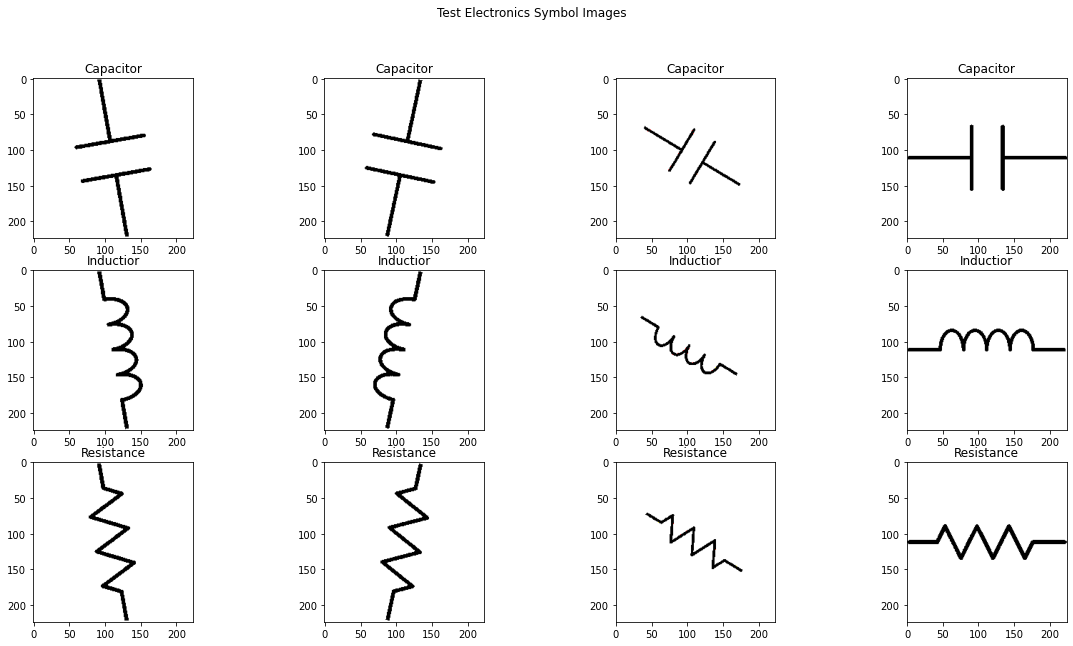

In [37]:
batch = evaluate_generator.next()
batch_images = evaluate_generator.next()[0]

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 10)) # define your figure and axes
ind = 0
for ax1 in axs:
    for ax2 in ax1: 
        image_data = batch_images[ind]
        ax2.imshow(image_data)
        ax2.title.set_text(result_index[ind])
        ind += 1

fig.suptitle('Test Electronics Symbol Images') 
plt.show()
